# Laboratorium 3 - Finetuning
*Andrzej Szarata - Grudzień 2025*

In [20]:
import torch
import random
import numpy as np
from datasets import load_from_disk, Dataset, DatasetDict
from tokenizers import Tokenizer
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import matplotlib.pyplot as plt

In [21]:
random_state = 42
random.seed(random_state)
np.random.seed(random_state)
torch.manual_seed(random_state)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")


## 1. Dataset

In [28]:
dataset = load_from_disk("../data/plslang")
tokenizer = Tokenizer.from_file("../tokenizers/polish-splade.json")

texts = dataset["tekst"]
labels = dataset["sentyment"]

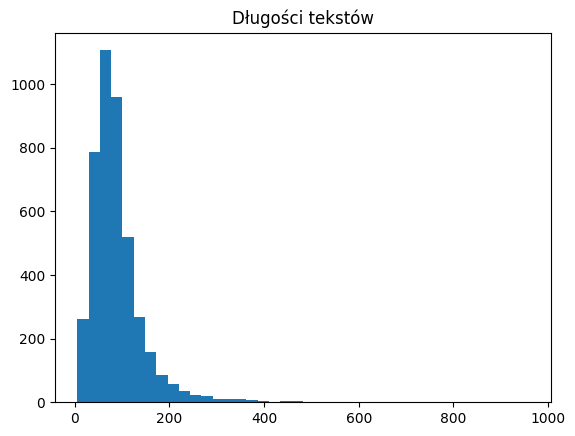

In [398]:
lengths = [len(t) for t in texts]
plt.hist(lengths, bins=40)
plt.title("Długości tekstów")
plt.show()

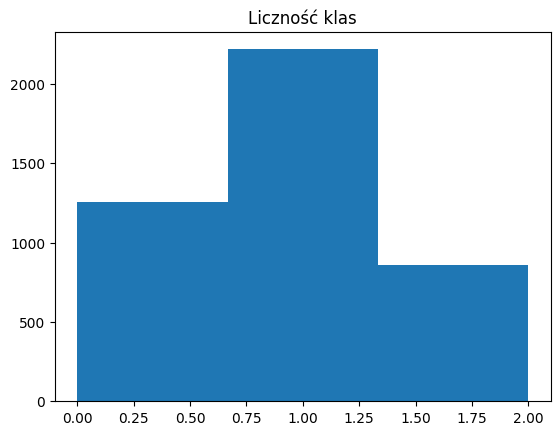

In [399]:
plt.hist(labels, bins=3)
plt.title("Liczność klas")
plt.show()

## 2. From-scratch model

### 2.1 Tokenization

In [25]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = self.tokenizer.encode(self.texts[idx])
        ids = torch.tensor(encoding.ids, dtype=torch.long)
        mask = torch.tensor(encoding.attention_mask, dtype=torch.long)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return ids, mask, label

def collate_fn(batch):
    ids = [x[0] for x in batch]
    masks = [x[1] for x in batch]
    labels = torch.tensor([x[2] for x in batch], dtype=torch.long)
    max_len = max(len(i) for i in ids)
    padded_ids = torch.zeros(len(ids), max_len, dtype=torch.long)
    padded_masks = torch.zeros(len(ids), max_len, dtype=torch.long)
    for i, (seq, mask) in enumerate(zip(ids, masks)):
        padded_ids[i, :len(seq)] = seq
        padded_masks[i, :len(mask)] = mask
    return padded_ids, padded_masks, labels

In [32]:
ds = TextDataset(texts, labels, tokenizer)
train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_state))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [29]:
vocab_size = tokenizer.get_vocab_size()
embed_dim = 128
hidden_dim = 128
num_classes = 3

top_k = 2048 

### 2.2 Model implementation

In [22]:
class Model(nn.Module):
    def __init__(self, n_position=512, embed_dim=128, hidden_dim=256, num_heads=4, n_layers=2, dropout_prob=0.3, n_classes=3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos = self.pos_emb = nn.Embedding(n_position, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_prob, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers, enable_nested_tensor=False)
        self.fc = nn.Linear(embed_dim, n_classes)

    def forward(self, x, attention_mask):
        x = self.embedding(x) + self.pos(torch.arange(x.shape[1]).to(x))
        padding_mask = (attention_mask == 0)

        x = self.transformer(x, src_key_padding_mask=padding_mask)

        attention_mask = attention_mask.unsqueeze(-1).float()
        x *= attention_mask
        x = x.sum(dim=1) / attention_mask.sum(dim=1).clamp(min=1e-9)

        x = self.fc(x)
        return x

### 2.3 Model parameters

In [ ]:
from copy import deepcopy

model = Model(
    n_position=128, 
    embed_dim=128, 
    hidden_dim=512, 
    num_heads=8, 
    n_layers=2, 
    dropout_prob=0.3,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

epochs = 50
train_losses = []
val_losses = []

best_model = deepcopy(model)
bes_val_loss = torch.inf

early_stopping_patience = 5

In [43]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 6,813,443


### 2.4 Training

In [406]:
from tqdm import tqdm

steps_no_progress = 0
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    with tqdm(train_loader, "Training") as pbar:
        for x, mask, y in pbar:
            x, y = x.to(device), y.to(device)
            mask = mask.to(device)
            optimizer.zero_grad()
            out = model(x, mask)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})

        train_losses.append(total_train_loss / len(train_loader))

    model.eval()
    total_val_loss = 0
    with tqdm(val_loader, "Validation") as pbar:
        with torch.no_grad():
            for x, mask, y in pbar:
                x, y = x.to(device), y.to(device)
                mask = mask.to(device)
                out = model(x, mask)
                loss = criterion(out, y)
                total_val_loss += loss.item()
                pbar.set_postfix({"loss": loss.item()})

    steps_no_progress += 1
    if total_val_loss / len(val_loader) < bes_val_loss:
        steps_no_progress = 0
        bes_val_loss = total_val_loss / len(val_loader)
        best_model = deepcopy(model)

    val_losses.append(total_val_loss / len(val_loader))

    print(f"Epoch: {epoch} | Train loss: {total_train_loss/ len(train_loader)} | Validation loss: {total_val_loss/ len(val_loader)}")

    if steps_no_progress >= early_stopping_patience:
        print("Early stop.")
        break 

Validation: 100%|██████████| 28/28 [00:00<00:00, 94.87it/s, loss=1.39] 


Epoch: 0 | Train loss: 1.0175086677349108 | Validation loss: 0.9775250000613076


Validation: 100%|██████████| 28/28 [00:00<00:00, 116.34it/s, loss=1.09] 


Epoch: 1 | Train loss: 0.9924564597793438 | Validation loss: 0.9523223744971412


Validation: 100%|██████████| 28/28 [00:00<00:00, 118.72it/s, loss=1.31] 


Epoch: 2 | Train loss: 0.9763104165754011 | Validation loss: 0.9454039931297302


Validation: 100%|██████████| 28/28 [00:00<00:00, 118.10it/s, loss=1.33] 


Epoch: 3 | Train loss: 0.9647749066352844 | Validation loss: 0.9368747962372643


Validation: 100%|██████████| 28/28 [00:00<00:00, 116.42it/s, loss=1.2]  


Epoch: 4 | Train loss: 0.9476163192278778 | Validation loss: 0.9318571814468929


Validation: 100%|██████████| 28/28 [00:00<00:00, 121.08it/s, loss=1.18] 


Epoch: 5 | Train loss: 0.937277006663485 | Validation loss: 0.9176054958786283


Validation: 100%|██████████| 28/28 [00:00<00:00, 110.16it/s, loss=1.14] 


Epoch: 6 | Train loss: 0.9186530481285763 | Validation loss: 0.9111452315534864


Validation: 100%|██████████| 28/28 [00:00<00:00, 125.36it/s, loss=1.24] 


Epoch: 7 | Train loss: 0.903839749949319 | Validation loss: 0.902088789003236


Validation: 100%|██████████| 28/28 [00:00<00:00, 119.54it/s, loss=1.34] 


Epoch: 8 | Train loss: 0.891625375516953 | Validation loss: 0.9124990212065833


Validation: 100%|██████████| 28/28 [00:00<00:00, 116.09it/s, loss=1.43] 


Epoch: 9 | Train loss: 0.8718390974306292 | Validation loss: 0.9063448693071093


Validation: 100%|██████████| 28/28 [00:00<00:00, 121.17it/s, loss=1.07] 


Epoch: 10 | Train loss: 0.8515569584160906 | Validation loss: 0.897624284029007


Validation: 100%|██████████| 28/28 [00:00<00:00, 118.92it/s, loss=0.847]


Epoch: 11 | Train loss: 0.8342679030334894 | Validation loss: 0.9107601003987449


Validation: 100%|██████████| 28/28 [00:00<00:00, 112.05it/s, loss=1.21] 


Epoch: 12 | Train loss: 0.8231851865069657 | Validation loss: 0.8941310197114944


Validation: 100%|██████████| 28/28 [00:00<00:00, 123.64it/s, loss=1.28] 


Epoch: 13 | Train loss: 0.7990795327221742 | Validation loss: 0.9049696688141141


Validation: 100%|██████████| 28/28 [00:00<00:00, 119.11it/s, loss=1.07] 


Epoch: 14 | Train loss: 0.777856027338362 | Validation loss: 0.9060570682798114


Validation: 100%|██████████| 28/28 [00:00<00:00, 115.63it/s, loss=0.973]


Epoch: 15 | Train loss: 0.7619531040642119 | Validation loss: 0.9234505529914584


Validation: 100%|██████████| 28/28 [00:00<00:00, 122.41it/s, loss=1.07] 


Epoch: 16 | Train loss: 0.743590988047112 | Validation loss: 0.9166846105030605


Validation: 100%|██████████| 28/28 [00:00<00:00, 115.80it/s, loss=0.897]

Epoch: 17 | Train loss: 0.7252934321005773 | Validation loss: 0.9285830472196851
Early stop.


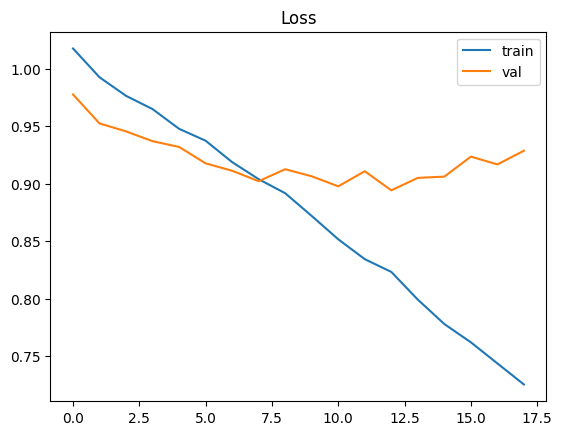

In [407]:
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.title("Loss")
plt.show()

### 2.5 Scores

In [408]:
from sklearn.metrics import classification_report

best_model.eval()
preds = []
trues = []
with torch.no_grad():
    for x, mask, y in test_loader:
        x = x.to(device)
        mask = mask.to(device)
        out = best_model(x, mask)
        p = out.argmax(dim=1).cpu().tolist()
        preds.extend(p)
        trues.extend(y.tolist())

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

accuracy = np.sum(np.array(trues) == np.array(preds)) / len(trues)
precision = precision_score(trues, preds, average='weighted', zero_division=0)
recall = recall_score(trues, preds, average='weighted', zero_division=0)
f1 = f1_score(trues, preds, average='weighted', zero_division=0)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print('Confusion matrix:')
print(confusion_matrix(trues, preds))

Accuracy: 0.5471
Precision: 0.5207
Recall: 0.5471
F1: 0.4919
Confusion matrix:
[[ 19 103   9]
 [ 13 188  16]
 [ 12  44  31]]


In [39]:
model = Model(
    n_position=128, 
    embed_dim=128, 
    hidden_dim=512, 
    num_heads=8, 
    n_layers=2, 
    dropout_prob=0.3,
).to(device)

In [42]:
import time

for _ in range(10):
    _ = model(x, mask)

model.eval()

start_time = time.perf_counter()
with torch.no_grad():
    for x, mask, y in test_loader:
        x = x.to(device)
        mask = mask.to(device)
        out = model(x, mask)
        p = out.argmax(dim=1).cpu().tolist()

inference_time = time.perf_counter() - start_time
    
mean_time = inference_time / (len(test_loader) * 16)
print(f"Inference: {mean_time:.6f}s")

Inference: 0.000466s


## 3. Pretrained model finetuning

### 3.1 Model

In [36]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate
import pandas as pd
from datasets import load_from_disk, Dataset, DatasetDict

tokenizer = AutoTokenizer.from_pretrained("allegro/herbert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("allegro/herbert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allegro/herbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 124,445,187


### 3.2 Tokenization and data preparation

In [ ]:
dataset = Dataset.from_dict({"text": texts, "label": labels})

split = dataset.train_test_split(test_size=0.2, seed=random_state)
tmp = split["train"].train_test_split(test_size=0.125, seed=random_state)
dataset_dict = DatasetDict({
    "train": tmp["train"],
    "val": tmp["test"],
    "test": split["test"]
})

In [6]:
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

tokenized = dataset_dict.map(tokenize_fn, batched=True)
tokenized = tokenized.remove_columns(["text"])
tokenized.set_format("torch")

Map: 100%|██████████| 868/868 [00:00<00:00, 28653.50 examples/s]


In [7]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": (preds == labels).mean()}

### 3.3 Training

In [ ]:
training_args = TrainingArguments(
    output_dir="../models/plslang",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/var/folders/tr/fv7hj1555_7_dl5892_yp6jc0000gn/T/ipykernel_4112/8887500.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 0}.
/Users/aszarata/informatyka/9s/lingwistyka/lab02/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.871300,0.740333,0.675115
2,0.628400,0.687276,0.705069
3,0.448400,0.736721,0.716590


/Users/aszarata/informatyka/9s/lingwistyka/lab02/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/aszarata/informatyka/9s/lingwistyka/lab02/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=1140, training_loss=0.6493728236148232, metrics={'train_runtime': 193.0781, 'train_samples_per_second': 47.157, 'train_steps_per_second': 5.904, 'total_flos': 598911917103360.0, 'train_loss': 0.6493728236148232, 'epoch': 3.0})

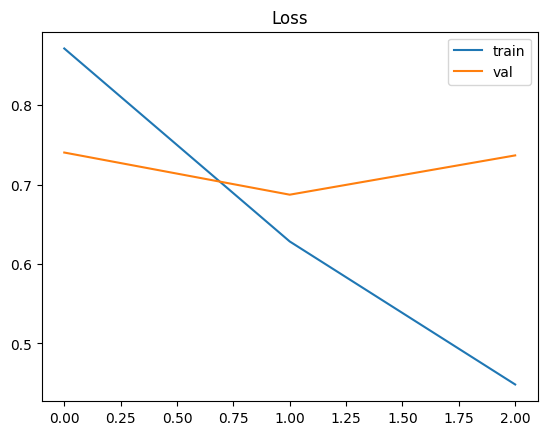

In [10]:
history = trainer.state.log_history

train_losses = [x["loss"] for x in history if "loss" in x]
eval_losses = [x["eval_loss"] for x in history if "eval_loss" in x]

plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="val")
plt.title("Loss")
plt.legend()
plt.show()

### 3.4 Scores

In [12]:
preds = trainer.predict(tokenized["test"])
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print('Confusion matrix:')
print(confusion_matrix(y_true, y_pred))

Accuracy: 0.6705
Precision: 0.6744
Recall: 0.6705
F1: 0.6714
Confusion matrix:
[[156  81   9]
 [ 95 313  34]
 [ 18  49 113]]


In [38]:
import time

trainer.predict(tokenized["test"])

start_time = time.perf_counter()
trainer.predict(tokenized["test"])
inference_time = time.perf_counter() - start_time
    
mean_time = inference_time / len(tokenized["test"])
print(f"Inference: {mean_time:.6f}s")

/Users/aszarata/informatyka/9s/lingwistyka/lab02/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Inference: 0.005355s
